# ARIMA Model

### Function to Check Stationarity Using Augmented Dickey-Fuller Test:

In [1]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_result(series):
    """
    Function To Perform Augmenter Dickey-Fuller Test and Display Results.
    """
    
    result= adfuller(series.dropna())
    
    labels = ["Test Statistics", "p-Value", "No. of Lags", "No. of Observations"]
    
    output = pd.Series(result[0:4], index= labels)
    
    for key,value in result[4].items():
        output[f"Critical Value {key}"] = value
        
    print(output)
    
    print("\n")
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [2]:
import numpy as np
import pandas as pd

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff

from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("TradeInventories.csv", index_col= 0, parse_dates= True)

In [4]:
df.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


In [5]:
df.shape

(264, 1)

In [6]:
df.index

DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='Date', length=264, freq=None)

In [7]:
df.index.freq = "MS"

In [8]:
df.index

DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='Date', length=264, freq='MS')

<AxesSubplot:xlabel='Date'>

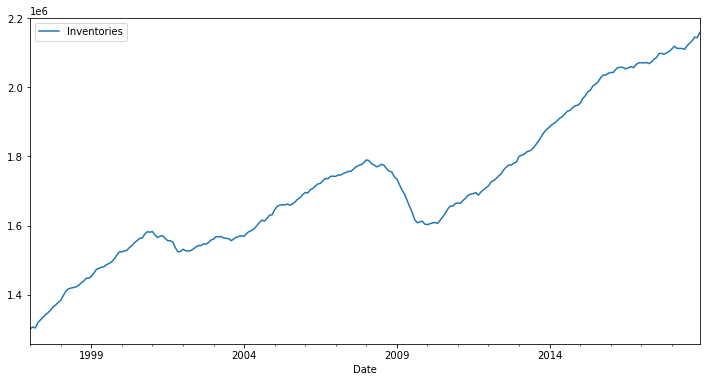

In [9]:
df.plot(figsize= (12,6))

### ETS Decomposition:

In [10]:
decomp = seasonal_decompose(df["Inventories"], model= "additive")

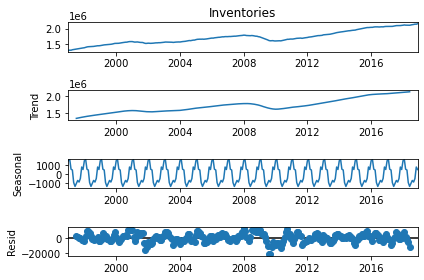

In [11]:
decomp.plot();

In [12]:
# There is some Seasonality in our data, but we will ignore it for now as it's quite small.

### Stationarity Check:

In [13]:
dickey_fuller_result(df["Inventories"])

Test Statistics         -0.087684
p-Value                  0.950652
No. of Lags              5.000000
No. of Observations    258.000000
Critical Value 1%       -3.455953
Critical Value 5%       -2.872809
Critical Value 10%      -2.572775
dtype: float64


Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [14]:
# Series is Non-Stationary.

# We have to apply Differencing.

In [15]:
df["Diff_1"] = diff(df["Inventories"], k_diff= 1)

In [16]:
df.head()

,Inventories,Diff_1
Date,,
1997-01-01,1301161,NaN
1997-02-01,1307080,5919.0
1997-03-01,1303978,-3102.0
1997-04-01,1319740,15762.0
1997-05-01,1327294,7554.0


In [17]:
# Checking Stationarity of First Order Differenced Data:

dickey_fuller_result(df["Diff_1"])

Test Statistics         -3.412249
p-Value                  0.010548
No. of Lags              4.000000
No. of Observations    258.000000
Critical Value 1%       -3.455953
Critical Value 5%       -2.872809
Critical Value 10%      -2.572775
dtype: float64


Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [18]:
# This is Stationary.

### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>

https://people.duke.edu/~rnau/411arim3.htm

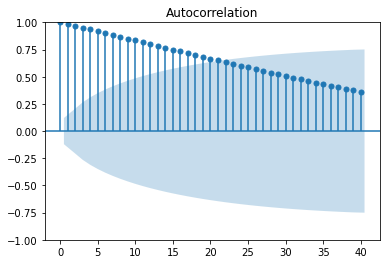

In [19]:
plot_acf(df["Inventories"], lags= 40);

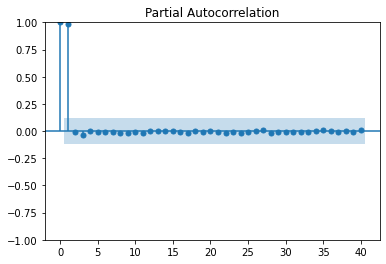

In [20]:
plot_pacf(df["Inventories"], lags= 40, method= "ywm");

In [21]:
# Looking at ACF and PACF Plots, Values of:

# p should be 1, d is 1 (first order differencing gave stationarity), and q should be either 0 or 1.

In [22]:
# Let's Confirm the same using Auto Arima.

In [23]:
grid_arima = auto_arima(df["Inventories"], start_p= 0, start_q= 0, max_p= 3, max_q= 3, seasonal= False,
                        trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.302 seconds


In [24]:
grid_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Wed, 23 Nov 2022   AIC                           5348.037
Time:                        21:12:59   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Auto Arima : p= 0, d= 1, q= 0

In [26]:
# We will Build Model Using Both values.

### Train Test Split:

In [27]:
len(df)

264

In [28]:
train_data = df[:252]
test_data = df[252:]

In [29]:
train_data.shape

(252, 2)

In [30]:
test_data.shape

(12, 2)

### ARIMA(1,1,1) Model:

In [31]:
model = ARIMA(train_data["Inventories"], order= (1,1,1))

In [32]:
results = model.fit()

C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2555.627
Date:                Wed, 23 Nov 2022   AIC                           5117.254
Time:                        21:12:59   BIC                           5127.830
Sample:                    01-01-1997   HQIC                          5121.510
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    855.681      0.000       0.998       1.002
ma.L1         -0.9999      0.033    -30.428      0.000      -1.064      -0.935
sigma2      2.975e+07   2.14e-10   1.39e+17      0.000    2.98e+07    2.98e+07
===================================================================================
Ljung-Box (L1) (Q):                  87.24   Jarque-Bera (JB):                98.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -1.17
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+32. Standard errors may be unstable.
"""

In [34]:
# Prediction on Test Data:

start = len(train_data)
end = len(train_data) + len(test_data) -1

In [35]:
preds = results.predict(start= start, end= end, dynamic= False, typ= "levels")

In [36]:
preds

2018-01-01    2.107107e+06
2018-02-01    2.110462e+06
2018-03-01    2.113818e+06
2018-04-01    2.117174e+06
2018-05-01    2.120529e+06
2018-06-01    2.123885e+06
2018-07-01    2.127241e+06
2018-08-01    2.130596e+06
2018-09-01    2.133952e+06
2018-10-01    2.137307e+06
2018-11-01    2.140663e+06
2018-12-01    2.144019e+06
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Date'>

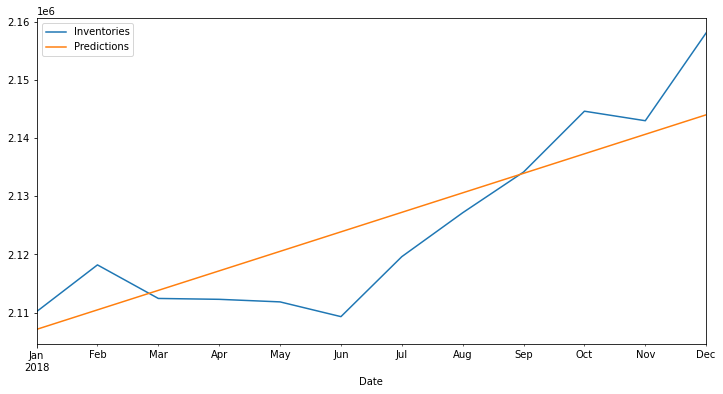

In [37]:
# Plotting Test Data and Predictions:

test_data["Inventories"].plot(figsize= (12,6), legend= True)
preds.plot(label= "Predictions", legend= True)

In [38]:
# Model Evaluation:

np.sqrt(mean_squared_error(test_data["Inventories"], preds))

7698.87945927603

In [39]:
# Retraining Model on Full Data to make Future Forecast:

model = ARIMA(df["Inventories"], order= (1,1,1))

In [40]:
results = model.fit()

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2672.278
Date:                Wed, 23 Nov 2022   AIC                           5350.555
Time:                        21:15:03   BIC                           5361.272
Sample:                    01-01-1997   HQIC                          5354.862
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    599.503      0.000       0.997       1.003
ma.L1         -0.9998      0.026    -37.939      0.000      -1.051      -0.948
sigma2      3.906e+07   4.44e-11   8.79e+17      0.000    3.91e+07    3.91e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):                94.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -1.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.66e+33. Standard errors may be unstable.
"""

In [42]:
forecast = results.predict(start= len(df), end= len(df)+12, typ= "levels")

In [43]:
forecast

2019-01-01    2.161371e+06
2019-02-01    2.164626e+06
2019-03-01    2.167882e+06
2019-04-01    2.171137e+06
2019-05-01    2.174393e+06
2019-06-01    2.177648e+06
2019-07-01    2.180904e+06
2019-08-01    2.184159e+06
2019-09-01    2.187415e+06
2019-10-01    2.190670e+06
2019-11-01    2.193925e+06
2019-12-01    2.197181e+06
2020-01-01    2.200436e+06
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Date'>

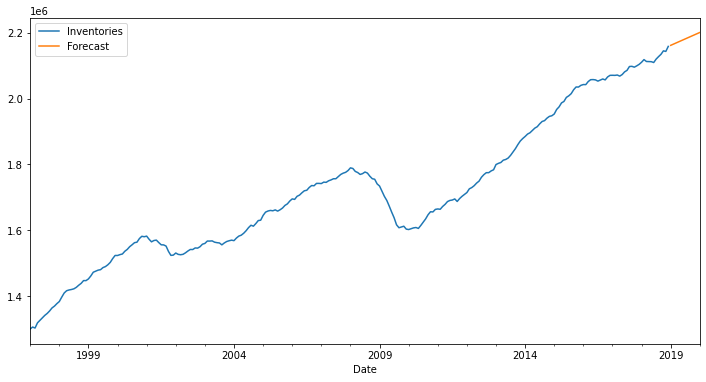

In [44]:
# Plotting Data and Forecast:

df["Inventories"].plot(figsize= (12,6), legend= True)
forecast.plot(label= "Forecast", legend= True)